# Transformers

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np

## Attention mechanism

$
    \text{Attention}(\mathbf{q}, \mathcal{D}) = \sum_i \alpha (\mathbf{q}, \mathbf{k}_i)\mathbf{v}_i
$

where:
- $\mathcal{D}$ is the database consisting of keys $\mathbf{k}$ and values $\mathbf{v}$
- $\alpha (\mathbf{q}, \mathbf{k}_i) \in \mathbb{R}$  are the attention weights

In [2]:
query = torch.tensor([0, 0, 0, 1, 0], dtype=torch.float32)
keys = torch.tensor([
    [1, 2, 3, 4, 5],
    [5, 4, 3, 2, 1],
    [9, 9, 9, 9, 9]
], dtype=torch.float32)
values = F.one_hot(torch.tensor([2, 4, 1]), num_classes=5).type(torch.float32)

attention_weights = F.softmax(keys @ query, dim=0)

attention_weights @ values, attention_weights

(tensor([0.0000e+00, 9.9241e-01, 6.6868e-03, 0.0000e+00, 9.0496e-04]),
 tensor([6.6868e-03, 9.0496e-04, 9.9241e-01]))

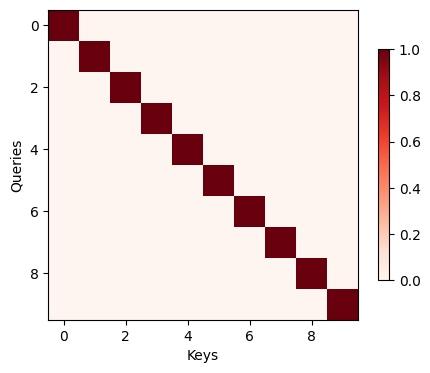

In [3]:
def visualize_keys_queries(matrices: torch.Tensor, xlabel: str, ylabel: str, cmap='Reds'):
    rows, cols, _, _ = matrices.shape
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows), sharex=True, sharey=True, squeeze=False)
    
    for row_axes, row_matrices in zip(axes, matrices):
        for ax, matrix in zip(row_axes, row_matrices):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
    plt.colorbar(pcm, ax=axes, shrink=0.6)
    
x = torch.eye(10).reshape(1, 1, 10, 10)
visualize_keys_queries(x, "Keys", "Queries")

## Attention pooling via Nadaraya-Watson regression

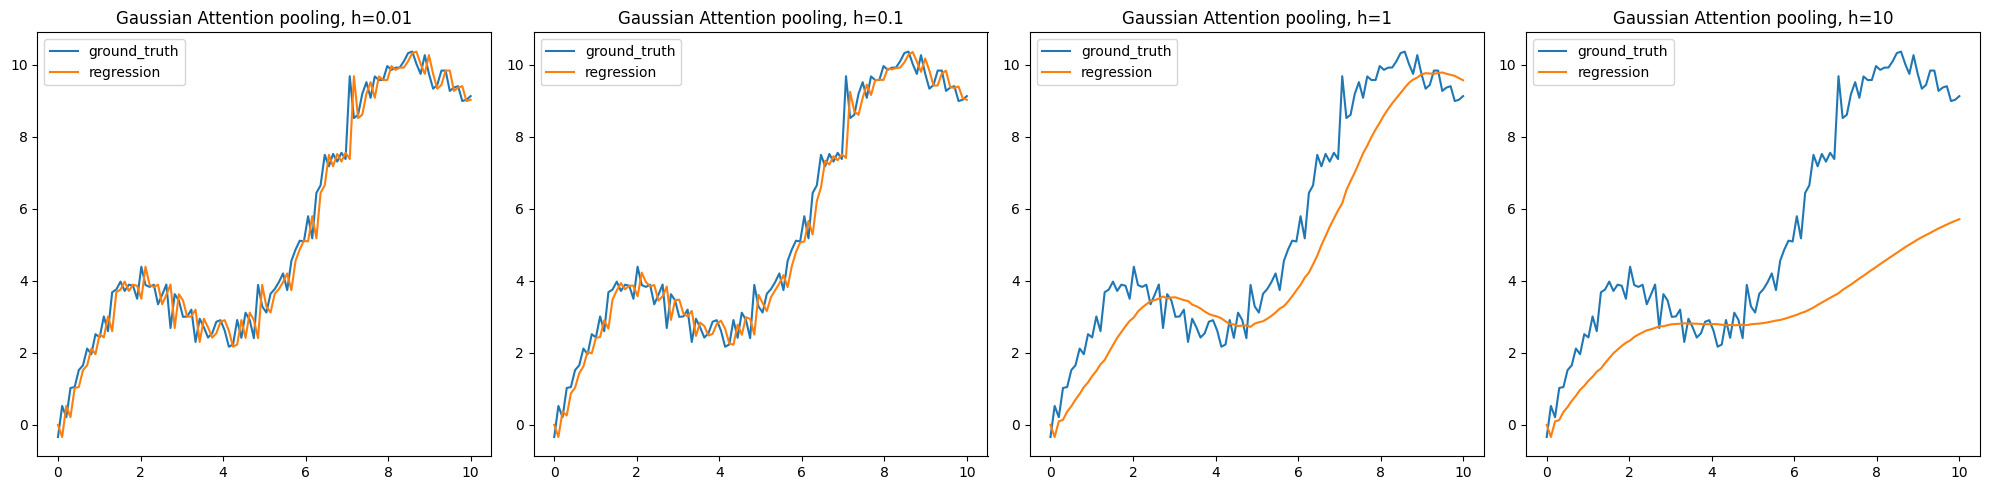

In [4]:
N = 100
x = torch.linspace(0, 10, N)
y = 2 * torch.sin(x) + x + torch.randn(N)*.4
h = [0.01, 0.1, 1, 10]

gauss_kernel = lambda q, x, h: torch.exp(-0.5 * (q - x[x < q])**2 / h**2)

fig, axes = plt.subplots(1, len(h), figsize=(len(h)*5, 5))

for ax, hi in zip(axes, h):

    ax.plot(x, y, label='ground_truth')
    
    y_preds = []
    for q in x:
        weight = gauss_kernel(q, x, hi)
        weight_norm = weight / weight.sum()
        
        y_pred = torch.sum(y[x < q] * weight_norm)
        y_preds.append(y_pred)
        
    ax.plot(x, y_preds, label='regression')
    ax.set_title(f"Gaussian Attention pooling, h={hi}")
    ax.legend()
    
plt.tight_layout()

### evaluating multiple kernels
- gaussian: $\exp[-x^2 / 2]$
- boxcar: $|x| < 1$
- epanechikov: $\max(0, 1-|x|)$

In [5]:
def gaussian_kernel(x):
    return torch.exp(-.5 * x**2)

def boxcar_kernel(x):
    return torch.abs(x) < 1.0

def epanechikov_kernel(x):
    return torch.max(torch.zeros_like(x), 1 - torch.abs(x))

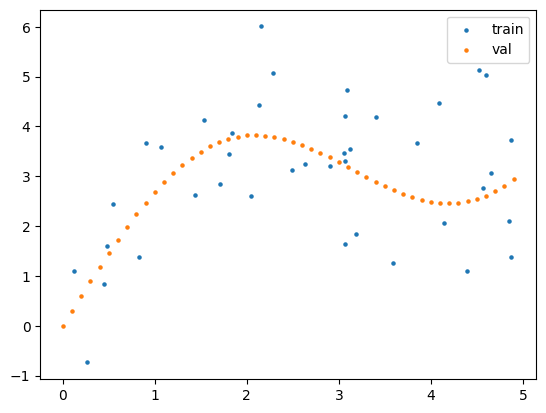

In [6]:
def f(x):
    return 2 * torch.sin(x) + x

N = 40
x_train, _ = torch.sort(torch.rand(N)*5)
y_train = f(x_train) + torch.randn(N)
x_val = torch.arange(0, 5, 0.1)
y_val = f(x_val)

plt.scatter(x_train, y_train, s=5, label='train')
plt.scatter(x_val, y_val, s=5, label='val')
plt.legend()

In [7]:
x_train.shape, x_val.shape, (x_train.reshape(-1, 1) - x_val.reshape(1, -1)).shape

(torch.Size([40]), torch.Size([50]), torch.Size([40, 50]))

In [8]:
def attention_regression(x_train, x_val, y_train, kernel):
    # distance matrix: each row/column contain key/query (x_train, x_val)
    dists = x_train.reshape(-1, 1) - x_val.reshape(1, -1)
    
    k = kernel(dists) # attention weights
    attention_w = k / k.sum(dim=0)
    
    # weigh previous y outcomes against normalised kernel attention 
    y_pred = y_train @ attention_w
    return y_pred, attention_w

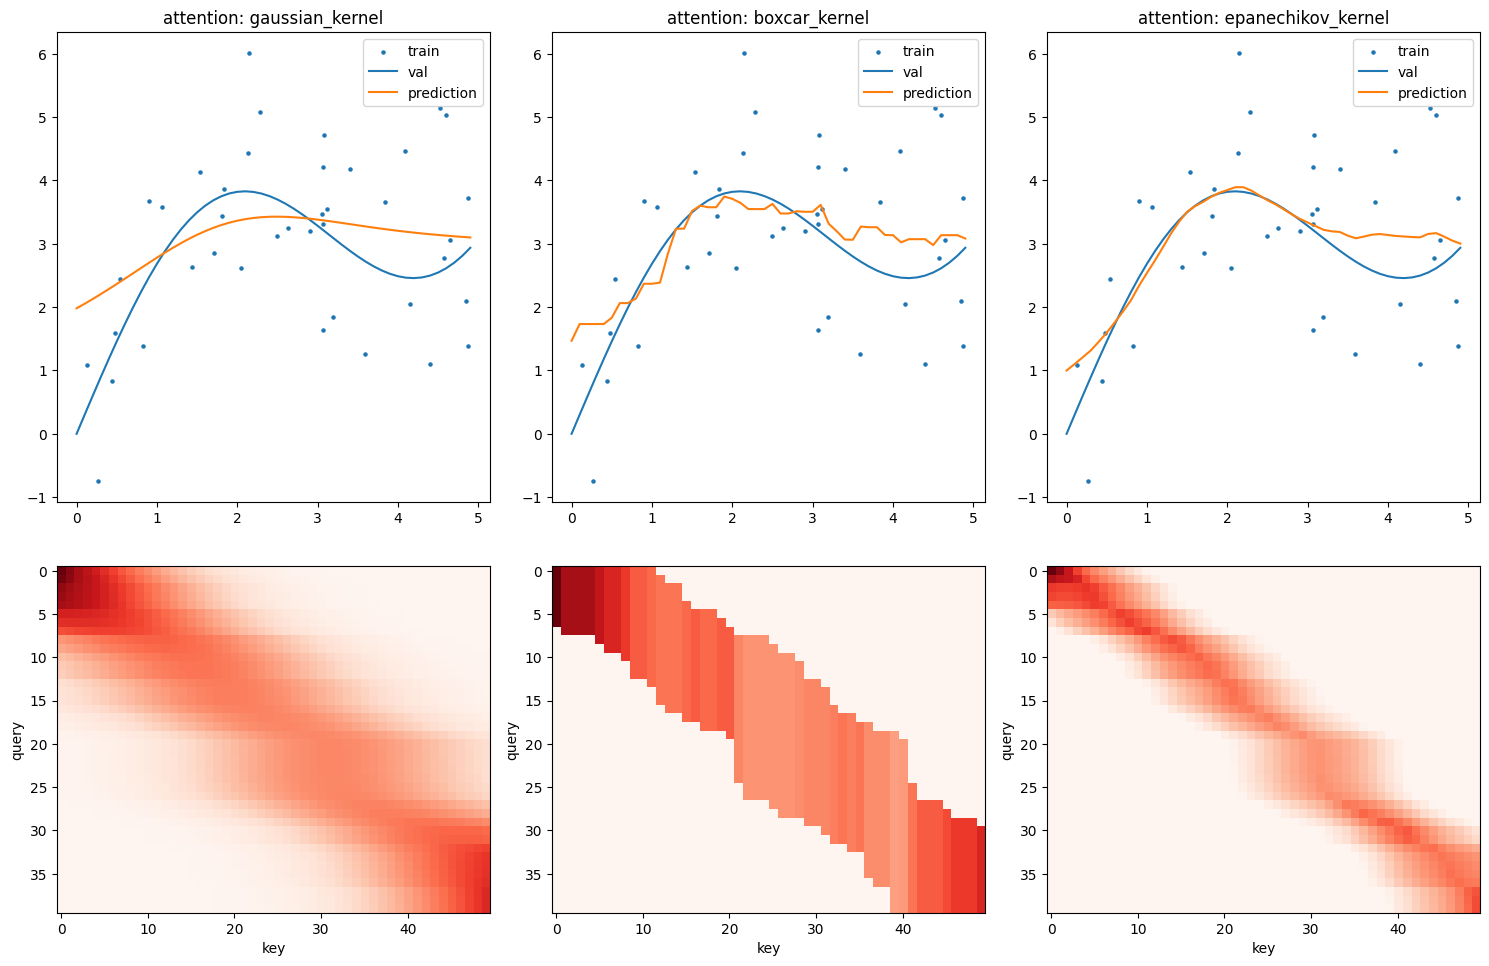

In [9]:
kernels = [gaussian_kernel, boxcar_kernel, epanechikov_kernel]

fig, axes = plt.subplots(2, len(kernels), figsize=(5*len(kernels), 10))

for ax, k in zip(axes.T, kernels):
    ax[0].scatter(x_train, y_train, s=5, label='train')
    ax[0].plot(x_val, y_val, label='val')
    y_pred, attention_w = attention_regression(x_train, x_val, y_train, k)
    ax[0].plot(x_val, y_pred, label='prediction')
    ax[0].set_title(f'attention: {k.__name__}')
    ax[0].legend()
    
    ax[1].imshow(attention_w.detach().numpy(), cmap='Reds')
    ax[1].set_xlabel("key")
    ax[1].set_ylabel("query")
plt.tight_layout()

Above distance matrix plot shows which keys are most relevent to which queries. 
- queries (x_val): the values we want to predict
- keys (x_train): the past values
- values (y_train): the outcomes of the past values

For example, if we want to query the value of x=30, then the 30th row of the attention weight matrix gives a vector of weights for the keys that are most relevant for this query (just like a database would return). Then, we take the dot product between the queried keys and the all past values to obtain the new outcome for x=30, i.e., y_pred.
  
The results from the kernels are similar because their attention weight matrix is also similar. This attention weight matrix now looks somewhat diagonal, because it considers a given window of keys (x_train) values for the prediction of a query (x_val). But this window may not be so linear, as is the case for sequences of words in natural language processing. 

### Testing pooled attention on classification problem


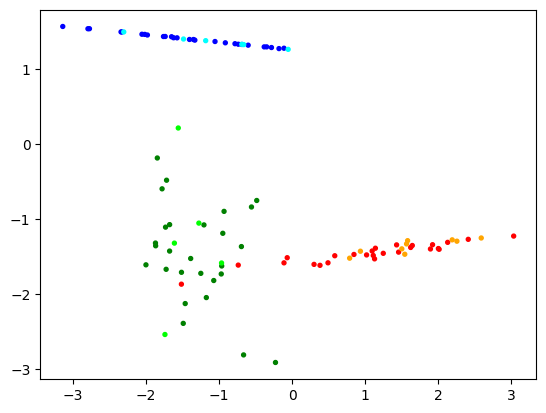

In [10]:
from sklearn.datasets import make_classification
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['red', 'blue', 'green'])
cmap1 = ListedColormap(['orange', 'cyan', 'lime'])

N = 100
x, y = make_classification(
    n_samples=N,
    n_features=2,
    n_classes=3,
    n_informative=2,
    n_repeated=0,
    n_redundant=0,
    n_clusters_per_class=1,
    class_sep=1.4
)

cutoff = int(N*.8)
x_train = torch.tensor(x[:cutoff]).type(torch.float32)
y_train = torch.tensor(y[:cutoff])
x_val = torch.tensor(x[cutoff:]).type(torch.float32)
y_val = torch.tensor(y[cutoff:])

x_min, x_max = x[:, 0].min() - 0.2, x[:, 0].max() + 0.2
y_min, y_max = x[:, 1].min() - 0.2, x[:, 1].max() + 0.2
XX, YY = np.meshgrid(np.linspace(x_min, x_max, 200),
                    np.linspace(y_min, y_max, 200))
D = np.vstack((XX.flatten(), YY.flatten())).T
D = torch.tensor(D).type(torch.float32)

plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, s=8, cmap=cmap)
plt.scatter(x_val[:, 0], x_val[:, 1], c=y_val, s=8, cmap=cmap1)

In [11]:
def gaussian_kernel2d(x, y):
     return torch.exp(-.5 * (x**2 + y**2))

def boxcar_kernel2d(x, y):
    return (torch.abs(x) < 1.0) & (torch.abs(y) < 1.0)

def epanechikov_kernel2d(x, y):
    return torch.max(torch.zeros_like(x), 1 - torch.abs(x) - torch.abs(y))

In [12]:
def attention_classification(x_train, x_val, y_train, kernel):
    # distance matrix with multiple features: (num_train, num_val, d)
    # each row/column contain key/query (x_train, x_val) 
    # each matrix cell cells contains feature vector of size d

    dists = (x_train.reshape(-1, 1, 2) - x_val.reshape(1, -1, 2))
    y_train_onehot = F.one_hot(y_train.type(torch.long), num_classes=3).type(torch.float32)
    
    k = kernel(dists[:, :, 0], dists[:, :, 1]) # attention weights
    attention_w = k / k.sum(dim=0, keepdim=True)
    
    # weigh previous y outcomes against normalised kernel attention 
    y_pred = (attention_w.T @ y_train_onehot)
    return y_pred, attention_w

y_pred, attention_w = attention_classification(x_train, x_val, y_train, gaussian_kernel2d)
y_pred.shape, attention_w.shape

(torch.Size([20, 3]), torch.Size([80, 20]))

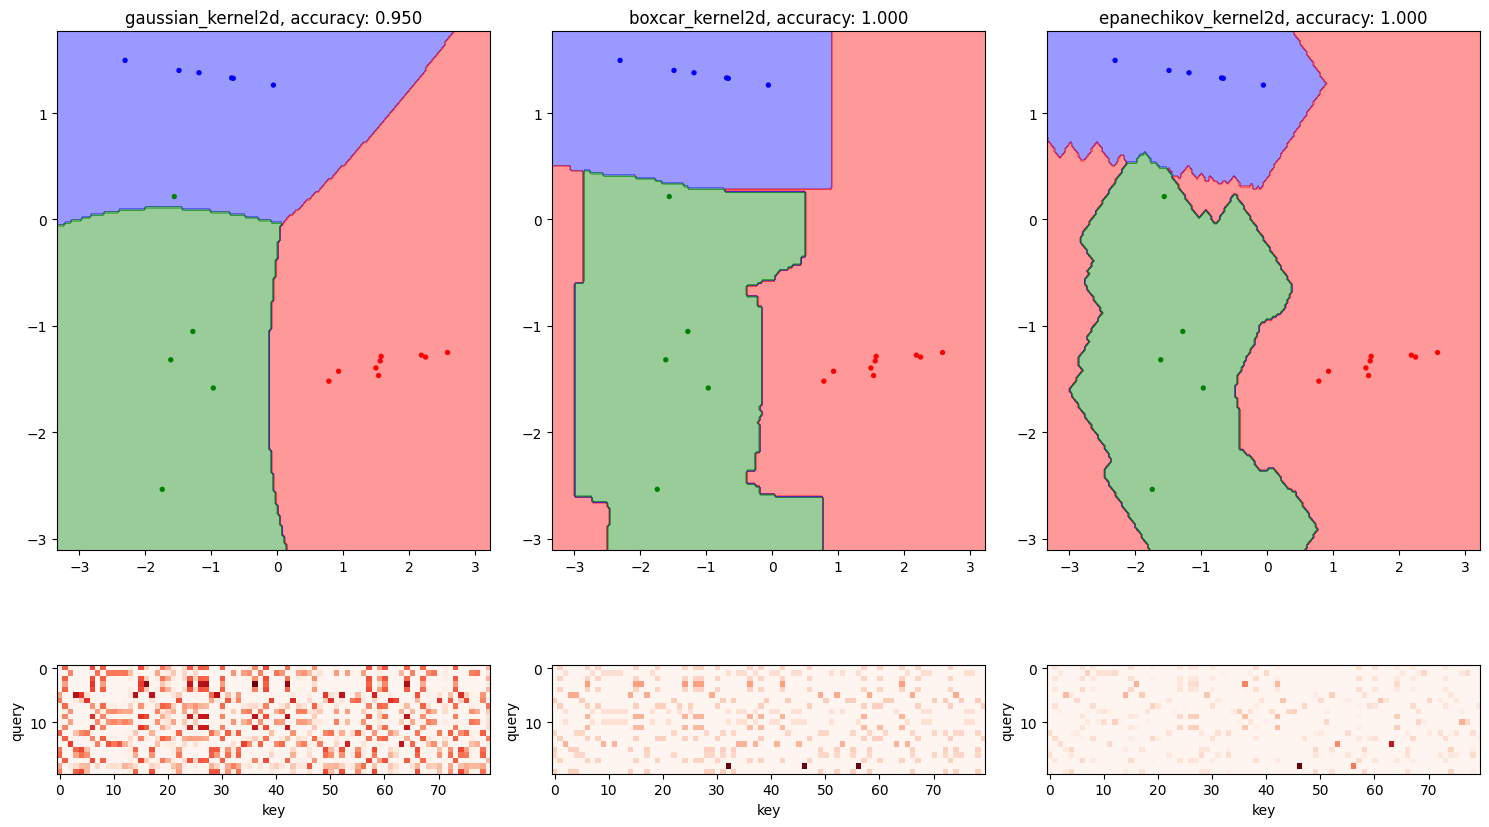

In [13]:
kernels = [gaussian_kernel2d, boxcar_kernel2d, epanechikov_kernel2d]

fig, axes = plt.subplots(2, len(kernels), figsize=(5*len(kernels), 10))

for ax, k in zip(axes.T, kernels[:]):
    
    y_pred, _ = attention_classification(x_train, D, y_train, k)
    y_pred = y_pred.argmax(dim=1).reshape(XX.shape)
    ax[0].contourf(XX, YY, y_pred, alpha=.4, cmap=cmap)
    
    y_pred, attention_w = attention_classification(x_train, x_val, y_train, k)
    acc = (y_pred.argmax(dim=1) == y_val).sum() / y_val.shape[0]
    
    ax[0].set_title(f"{k.__name__}, accuracy: {acc.item():.3f}")
    # ax[0].scatter(x_val[:, 0], x_val[:, 1], c=y_pred.argmax(dim=1), s=8, cmap=cmap)
    ax[0].scatter(x_val[:, 0], x_val[:, 1], c=y_val, s=8, cmap=cmap)
    
    ax[1].imshow(attention_w.T.detach().numpy(), cmap='Reds')
    ax[1].set_xlabel("key")
    ax[1].set_ylabel("query")
    
plt.tight_layout()

## Masked attention

Zero out softmax values for which the sequence of inputs is already terminated.

e.g., `hello world <blank>` for which we should not attend to the `<blank>` token


In [14]:
d = 100 # dimensionality
num_keys = 20
batch_size = 32

q = torch.randn(batch_size, d)
k = torch.randn(num_keys, d)

attention = ((q @ k.T) / num_keys**.5).softmax(dim=1)
attention.shape

torch.Size([32, 20])

In [15]:
def masked_softmax(X: torch.Tensor, valid_lenghts: torch.Tensor) -> torch.Tensor:
    # input: 3d tensor (batch_size, key_size, query_size)
    # valid_lengths: 1d tensor (valid_lens) or 2d tensor (key_size, valid_lens)
    
    if valid_lenghts is None:
        return F.softmax(X, dim=-1)
    else:
        shape = X.shape
        valid_lenghts = torch.repeat_interleave(valid_lenghts, shape[1]) \
                    if valid_lenghts.dim() == 1 else valid_lenghts.reshape(-1)
        
        X = X.reshape(-1, shape[-1])
        max_len = X.shape[1]
        mask = torch.arange(max_len, dtype=torch.float32)[None, :] < valid_lenghts[:, None]
        X[~mask] = -1e6
        return F.softmax(X.reshape(shape), dim=-1)
        
x = torch.randn(2, 2, 4)
print(x)
valid_len = torch.tensor([2, 3])
y = masked_softmax(x, valid_len)
y

tensor([[[ 0.9324,  1.2922, -1.8951, -0.4675],
         [-1.6406,  0.3838,  0.5813,  0.0922]],

        [[ 0.7762, -0.7210, -0.2946, -1.0478],
         [ 0.9239, -0.4286, -0.2233,  0.4255]]])


tensor([[[0.4110, 0.5890, 0.0000, 0.0000],
         [0.1167, 0.8833, 0.0000, 0.0000]],

        [[0.6384, 0.1428, 0.2188, 0.0000],
         [0.6345, 0.1641, 0.2015, 0.0000]]])

## Batch matrix multiplication

- $\textbf{Q} = [Q_1, Q_2, \dots, Q_N] \in \mathbb{R}^{N \times a \times b}$
- $\textbf{K} = [K_1, K_2, \dots, K_N] \in \mathbb{R}^{N \times b \times c}$
- Batch Matrix Multiplication (BMM) computes the element-wise product
- $BMM(\textbf{Q}, \textbf{K}) = [Q_1 K_1, Q_2 K_2, \dots, Q_N K_N] \in \mathbb{R}^{N \times a \times c}$


In [16]:
Q = torch.randn(32, 8, 10)
K = torch.randn(32, 10, 4)

torch.bmm(Q, K).shape

torch.Size([32, 8, 4])

## Dot Product Attention

$\text{attention}(\textbf{Q}, \textbf{K}, \textbf{V}) = \text{softmax}\left(\dfrac{\textbf{Q}\textbf{K}^T}{\sqrt{d}}\right) \textbf{V}$

In [17]:
class DotProductAttention(nn.Module):
    def __init__(self, dropout_rate):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.attention_weights = None
    
    def forward(self, Q: torch.Tensor, K: torch.Tensor, V: torch.Tensor, valid_lengths=None):
        # Q: (batch_size, n_queries, d)
        # K: (batch_size, n_keyvals, d)
        # Q: (batch_size, n_keyvals, value_dim)
        d = Q.shape[-1]
        attention_scores = torch.bmm(Q, K.transpose(1, 2)) / d**.5
        self.attention_weights = masked_softmax(attention_scores, valid_lengths)
        return torch.bmm(self.dropout(self.attention_weights), V)
        
queries = torch.randn(4, 50, 16)
keys = torch.randn(4, 40, 16)
values = torch.randn(4, 40, 2)

attention = DotProductAttention(dropout_rate=.2)
attention.eval()
attention(queries, keys, values).shape, attention.attention_weights.shape

(torch.Size([4, 50, 2]), torch.Size([4, 50, 40]))

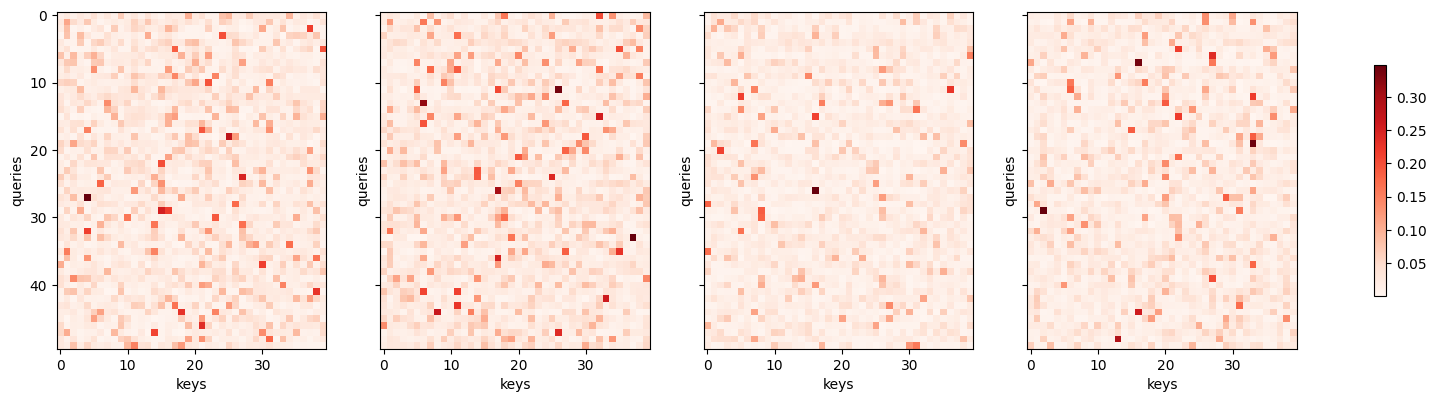

In [18]:
visualize_keys_queries(attention.attention_weights[None, :], xlabel='keys', ylabel='queries')

#### Nadaraya-Watson regression with learnable attention

Just like before, using the formulation of Nadaraya-Watson regression, we use **queries** to make predictions of y values based on x values, and use x_train values as **keys** and y_train values as **values**. 

Since the Dot product attention module has no trainable parameters, we transform the queries, keys, and values with a linear layer. The output of the attention mechanism goes through another linear layer to produce y_preds

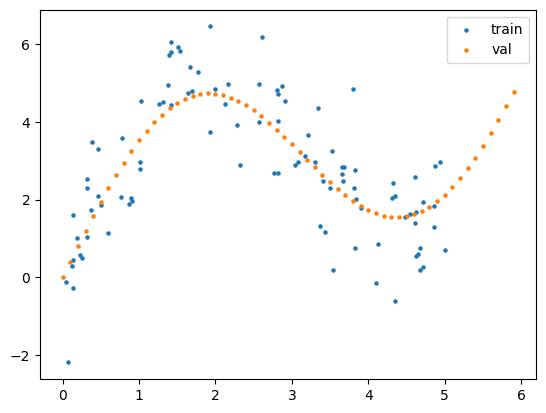

In [19]:
def f(x):
    return 3 * torch.sin(x) + x

N = 100
x_train, _ = torch.sort(torch.rand(N)*5)
y_train = f(x_train) + torch.randn(N)
x_val = torch.arange(0, 6, 0.1)
y_val = f(x_val)

plt.scatter(x_train, y_train, s=5, label='train')
plt.scatter(x_val, y_val, s=5, label='val')
plt.legend()

10.499056816101074
1.7979052066802979
1.5803145170211792
1.3431720733642578
0.8448551297187805
0.6002444624900818
0.5085124373435974
0.5528020858764648
0.49886271357536316
0.4781213700771332
0.4723925292491913
0.4619804322719574
0.44924023747444153
0.4841389060020447
0.47167813777923584
0.47787120938301086
0.46932095289230347
0.49853765964508057
0.49293267726898193
0.45613181591033936
0.4858179986476898
0.4714483320713043
0.4616203308105469
0.4479239881038666
0.47112980484962463
0.46305224299430847
0.46028560400009155
0.4738493859767914
0.48550766706466675
0.46199214458465576
0.4647655487060547
0.4752601087093353
0.46252214908599854
0.47204872965812683
0.47642797231674194
0.47834980487823486
0.4668576121330261
0.46878674626350403
0.4735367000102997
0.4765167534351349
0.45701414346694946
0.4756864607334137
0.47894567251205444
0.4549582302570343
0.4860907793045044
0.47380632162094116
0.4632352292537689
0.4593021273612976
0.4728941023349762
0.4800196886062622
0.4660326838493347
0.47259113

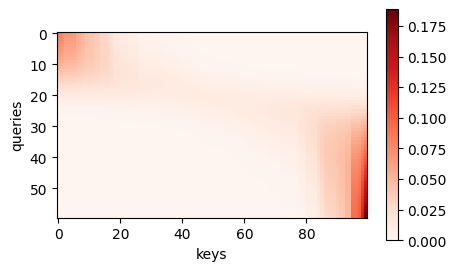

In [20]:
shaped_x_val = x_val.reshape(1, -1, 1)
shaped_x_train = x_train.reshape(1, -1, 1)
shaped_y_train = y_train.reshape(1, -1, 1)

attention = DotProductAttention(dropout_rate=0.01)
Q_layer = nn.Linear(1, 8) # (input_dim, num_queries)
K_layer = nn.Linear(1, 8) # (input_dim, num_key_val_pairs)
V_layer = nn.Linear(1, 16)  # (input_dim, value_dim)
output_layer = nn.Sequential(nn.Linear(16, 1))

optim = torch.optim.Adam([
    *Q_layer.parameters(), 
    *K_layer.parameters(), 
    *V_layer.parameters(),
    *output_layer.parameters()], lr=0.001)

for i in range(10000):
    queries = Q_layer(shaped_x_val)
    keys = K_layer(shaped_x_train)
    values = V_layer(shaped_y_train)

    hidden = attention(queries, keys, values)
    y_pred = output_layer(hidden)
    
    loss = F.mse_loss(y_pred.squeeze(), y_val)
    optim.zero_grad()
    loss.backward()
    optim.step()
    if i % 100 == 0:
        print(loss.item())

visualize_keys_queries(attention.attention_weights[None, :], xlabel='keys', ylabel='queries')

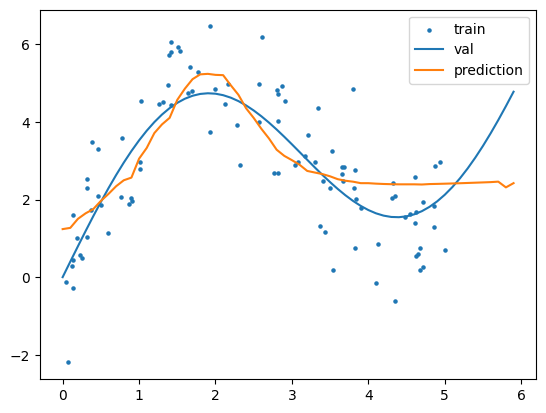

In [21]:
plt.scatter(x_train, y_train, s=5, label='train')
plt.plot(x_val, y_val, label='val')

queries = Q_layer(shaped_x_val)
keys = K_layer(shaped_x_train)
values = V_layer(shaped_y_train)

hidden = attention(queries, keys, values)
y_pred = output_layer(hidden)

plt.plot(x_val, y_pred.detach().squeeze(), label='prediction')
plt.legend()

## Additive attention

If $\textbf{q} \in \mathbb{R}^q$ and $\textbf{k} \in \mathbb{R}^k$ with $q \neq k$, then we can introduce an intermediate linear transformation to match the dimensions. Another option is to use additive attention, which is defined as:

$a(\textbf{q}, \textbf{k}) = \textbf{w}_v^T \text{tanh}(\textbf{W}_q \textbf{q} + \textbf{W}_k \textbf{k})$

where:
- $\textbf{W}_q \in \mathbb{R}^{h \times q}$
- $\textbf{W}_k \in \mathbb{R}^{h \times k}$
- $\textbf{w}_v \in \mathbb{R}^{h}$

In [22]:
class AdditiveAttention(nn.Module):
    def __init__(self, num_hidden, dropout_rate):
        super().__init__()
        self.W_k = nn.LazyLinear(num_hidden, bias=False)
        self.W_q = nn.LazyLinear(num_hidden, bias=False)
        self.w_v = nn.LazyLinear(1, bias=False)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.attention_weights = None
    
    def forward(self, Q: torch.Tensor, K: torch.Tensor, V: torch.Tensor, valid_lengths=None):
        # Q: (batch_size, n_queries, d)
        # K: (batch_size, n_keyvals, d)
        # Q: (batch_size, n_keyvals, value_dim)
        queries, keys = self.W_q(Q), self.W_k(K)
        # to sum, 
        # queries needs to be (batch_size, n_queries, 1, d) and
        # keys needs to be (batch_size, 1, n_queries, d)
        features = queries.unsqueeze(dim=2) + keys.unsqueeze(dim=1)
        features = F.tanh(features)
        scores = self.w_v(features).squeeze(dim=-1)
        self.attention_weights = masked_softmax(scores, valid_lengths)
        return torch.bmm(self.dropout(self.attention_weights), V)
        
queries = torch.randn(4, 50, 16)
keys = torch.randn(4, 40, 16)
values = torch.randn(4, 40, 2)

attention = AdditiveAttention(8, dropout_rate=.2)
attention.eval()
attention(queries, keys, values).shape, attention.attention_weights.shape

C:\Users\janba\python-dev\deeplearning_notebooks\venv\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


(torch.Size([4, 50, 2]), torch.Size([4, 50, 40]))

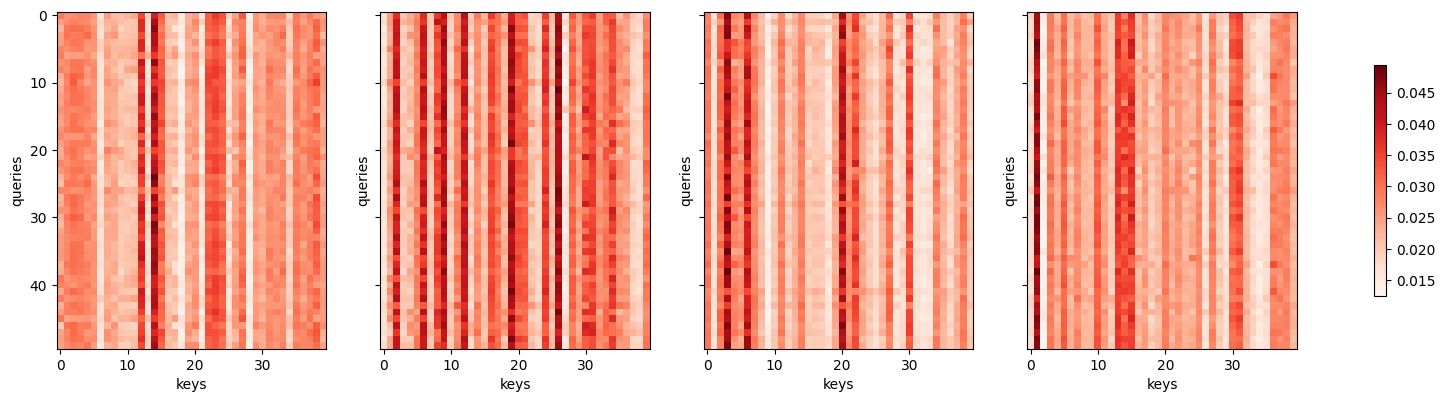

In [23]:
visualize_keys_queries(attention.attention_weights[None, :], xlabel='keys', ylabel='queries')

#### Nadaraya-Watson regression with learnable attention

Just like before, using the formulation of Nadaraya-Watson regression, we use **queries** to make predictions of y values based on x values, and use x_train values as **keys** and y_train values as **values**. 

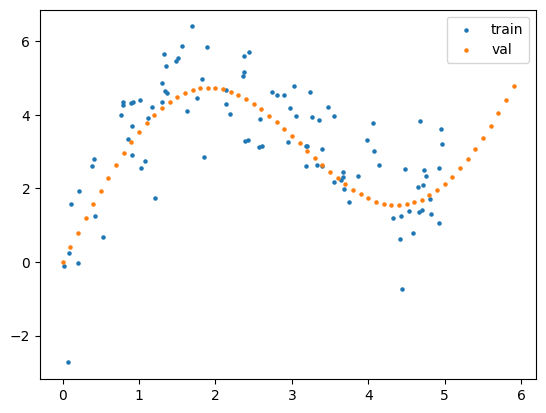

In [24]:
def f(x):
    return 3 * torch.sin(x) + x

N = 100
x_train, _ = torch.sort(torch.rand(N)*5)
y_train = f(x_train) + torch.randn(N)
x_val = torch.arange(0, 6, 0.1)
y_val = f(x_val)

plt.scatter(x_train, y_train, s=5, label='train')
plt.scatter(x_val, y_val, s=5, label='val')
plt.legend()

21.164987564086914
1.5624816417694092
1.5157756805419922
1.5137289762496948
1.4834091663360596
1.4713014364242554
1.4482816457748413
1.4300681352615356
1.3657065629959106
1.3227877616882324
1.2343553304672241
1.247064471244812
1.1717082262039185
1.1578290462493896
1.099092960357666
1.1003005504608154
1.0496432781219482
0.9841686487197876
0.9641923904418945
0.9397563934326172
0.8938944339752197
0.8510981798171997
0.8296606540679932
0.7861664891242981
0.7554075717926025
0.7934109568595886
0.7589851021766663
0.7542415261268616
0.7239891290664673
0.7084535956382751
0.6900548338890076
0.6865362524986267
0.672958493232727
0.659589409828186
0.6788942217826843
0.6619147062301636
0.6372543573379517
0.6542039513587952
0.6383970975875854
0.6272208094596863


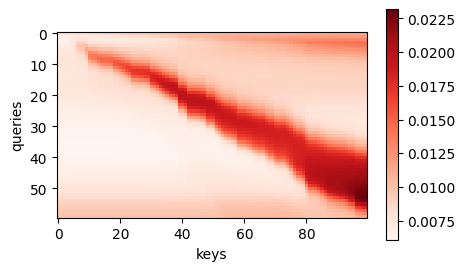

In [25]:
shaped_x_val = x_val.reshape(1, -1, 1)
shaped_x_train = x_train.reshape(1, -1, 1)
shaped_y_train = y_train.reshape(1, -1, 1)

attention = AdditiveAttention(32, dropout_rate=0.01)
Q_layer = nn.Linear(1, 8, bias=False) # (input_dim, num_queries)
K_layer = nn.Linear(1, 8, bias=False) # (input_dim, num_key_val_pairs)
V_layer = nn.Linear(1, 16, bias=False)  # (input_dim, value_dim)
output_layer = nn.Sequential(nn.Linear(16, 1))

optim = torch.optim.Adam([
    *Q_layer.parameters(), 
    *K_layer.parameters(), 
    *V_layer.parameters(),
    *output_layer.parameters()], lr=0.001)

for i in range(20000):
    queries = Q_layer(shaped_x_val)
    keys = K_layer(shaped_x_train)
    values = V_layer(shaped_y_train)

    hidden = attention(queries, keys, values)
    y_pred = output_layer(hidden)
    
    loss = F.mse_loss(y_pred.squeeze(), y_val)
    optim.zero_grad()
    loss.backward()
    optim.step()
    if i % 500 == 0:
        print(loss.item())

visualize_keys_queries(attention.attention_weights[None, :], xlabel='keys', ylabel='queries')

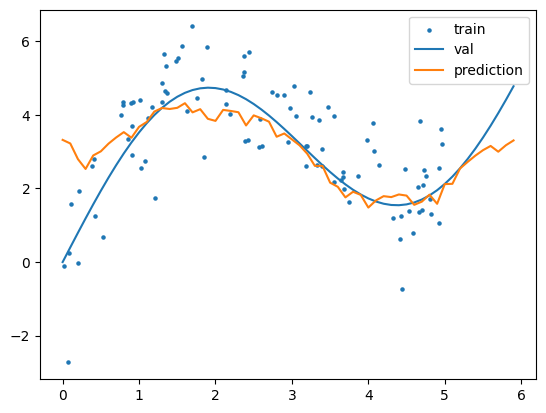

In [26]:
plt.scatter(x_train, y_train, s=5, label='train')
plt.plot(x_val, y_val, label='val')

queries = Q_layer(shaped_x_val)
keys = K_layer(shaped_x_train)
values = V_layer(shaped_y_train)

hidden = attention(queries, keys, values)
y_pred = output_layer(hidden)

plt.plot(x_val, y_pred.detach().squeeze(), label='prediction')
plt.legend()

## Seq2Seq Attention Decoder

In [27]:
class Seq2SeqEncoder(nn.Module):
    def __init__(self, vocab_size, emb_size, num_hidden, num_layers, dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.rnn = nn.GRU(input_size=emb_size, hidden_size=num_hidden, num_layers=num_layers, dropout=dropout)
    
    def forward(self, X):
        # X shape: (batch_size, num_steps)
        embs = self.embedding(X.T.type(torch.int64))
        # embs shape: (num_steps, batch_size, emb_size)
        outputs, state = self.rnn(embs)
        # outputs shape: (num_steps, batch_size, num_hidden)
        # state shape:   (num_layers, batch_size, num_hidden)
        return outputs, state

vocab_size = 10
emb_size = 8
num_hidden = 16
num_layers = 2
encoder = Seq2SeqEncoder(vocab_size, emb_size, num_hidden, num_layers)
batch_size, num_steps = 4, 9
x = torch.randint(0, 10, (batch_size, num_steps)) # (batch_size, num_steps)
enc_outs, enc_state = encoder(x)
enc_outs.shape, enc_state.shape

(torch.Size([9, 4, 16]), torch.Size([2, 4, 16]))

In [28]:
class Seq2SeqAttentionDecoder(nn.Module):
    def __init__(self, vocab_size, emb_size, num_hidden, num_layers, dropout_rate=0):
        super().__init__()
        self.attention = AdditiveAttention(num_hidden, dropout_rate=dropout_rate)
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.rnn = nn.GRU(input_size=emb_size + num_hidden, hidden_size=num_hidden, num_layers=num_layers, dropout=dropout_rate)
        self.dense = nn.LazyLinear(vocab_size)
        self.attention_weights = None
    
    def init_state(self, enc_outputs, enc_valid_lengths):
        outputs, hidden_state = enc_outputs
        # outputs: (num_steps, batch_size, num_hiddens)
        # hidden_state: (num_layers, batch_size, num_hiddens)
        return outputs.permute(1, 0, 2), hidden_state, enc_valid_lengths
    
    def forward(self, X, state):
        # enc_outputs:  (batch_size, num_steps, num_hiddens)
        # hidden_state: (num_layers, batch_size, num_hiddens)
        enc_outputs, hidden_state, enc_valid_lengths = state
        X = self.embedding(X).permute(1, 0, 2)
        # X : (num_steps, batch_size, embed_size)
        outputs, self.attention_weights = [], []
        for x in X: # for time step in X
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # query: (batch_size, 1, num_hiddens)
            context = self.attention(query, enc_outputs, enc_outputs, enc_valid_lengths)
            # context: (batch_size, 1, num_hiddens)
            
            x = torch.cat((context, x.unsqueeze(dim=1)), dim=-1)
            # x: (batch_size, embed_size) ---> (batch_size, 1, embed_size + num_hiddens)
            x = x.permute(1, 0, 2) # x (1, batch_size, embed_size + num_hiddens)
            
            out, hidden_state = self.rnn(x, hidden_state)
            outputs.append(out)
            self.attention_weights.append(self.attention.attention_weights)
        
        outputs = self.dense(torch.cat(outputs, dim=0))
        # outputs: (num_steps, batch_size, vocab_size)
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state, enc_valid_lengths]

vocab_size = 10
emb_size = 8
num_hidden = 16
num_layers = 2
encoder = Seq2SeqEncoder(vocab_size, emb_size, num_hidden, num_layers)
decoder = Seq2SeqAttentionDecoder(vocab_size, emb_size, num_hidden, num_layers)
batch_size, num_steps = 4, 9
x = torch.randint(0, 10, (batch_size, num_steps)) # (batch_size, num_steps)

state = decoder.init_state(encoder(x), None)
output, state = decoder(x, state)

output.shape, state[0].shape, state[1].shape

(torch.Size([4, 9, 10]), torch.Size([4, 9, 16]), torch.Size([2, 4, 16]))

In [29]:
class EncoderDecoder(nn.Module):

    def __init__(self, encoder, decoder, tgt_pad=None):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.tgt_pad = tgt_pad

    def forward(self, enc_X, dec_X):
        enc_all_outputs = self.encoder(enc_X)
        dec_state = self.decoder.init_state(enc_all_outputs, None)
        # Return decoder output only
        return self.decoder(dec_X, dec_state)[0]

    def predict_step(self, batch, device, num_steps, save_attention_weights=False):
        
        batch = [a.to(device) for a in batch]
        src, tgt, src_valid_len, _ = batch
        enc_all_outputs = self.encoder(src, src_valid_len)
        dec_state = self.decoder.init_state(enc_all_outputs, src_valid_len)
        outputs, attention_weights = [torch.unsqueeze(tgt[:, 0], 1), ], []
        for _ in range(num_steps):
            Y, dec_state = self.decoder(outputs[-1], dec_state)
            outputs.append(torch.argmax(Y, dim=2))
            # Save attention weights
            if save_attention_weights:
                attention_weights.append(self.decoder.attention_weights)
        return torch.concat(outputs[1:], 1), attention_weights


### Vocab class and Dataset

In [30]:
from collections import Counter

class Vocab:
    
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        # Flatten a 2D list if needed
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        # Count token frequencies
        counter = Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        # The list of unique tokens
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [
            token for token, freq in self.token_freqs if freq >= min_freq])))
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}
    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]

    @property
    def unk(self):  # Index for the unknown token
        return self.token_to_idx['<unk>']

In [31]:
from torch.utils.data import IterableDataset, DataLoader

class SeqFrenchEnglish(IterableDataset):
    FILE_PATH = '../datasets/fra.txt'
    
    def __init__(self, batch_size, num_steps=9, num_train=512, num_val=128):
        self.batch_size = batch_size
        self.num_steps = num_steps
        self.num_train = num_train
        self.num_val = num_val
        self.arrays, self.src_vocab, self.tgt_vocab = self.build_arrays(self.import_dataset(self.FILE_PATH))
    
    @staticmethod
    def import_dataset(file_name):
        f = open(file_name, 'r', encoding='utf-8')
        text = f.read()
        text.replace('\u202f', ' ').replace('\xa0', ' ') # non-breaking space --> space
        no_space = lambda char, prev_char: char in ',.!?' and prev_char != ' '
        out = [' ' + char if i > 0 and no_space(char, text[i-1]) else char 
               for i, char in enumerate(text)]
        return ''.join(out)
    
    def build_arrays(self, text, src_vocab=None, tgt_vocab=None):
        def _build_array(sentences, vocab, is_tgt=False):
            pad_or_trim = lambda seq, t: (
                seq[:t] if len(seq) > t else seq + ['<pad>'] * (t - len(seq)))
            sentences = [pad_or_trim(s, self.num_steps) for s in sentences]
            if is_tgt:
                sentences = [['<bos>'] + s for s in sentences]
            if vocab is None:
                vocab = Vocab(sentences, min_freq=2)
            array = torch.tensor([vocab[s] for s in sentences])
            valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
            return array, vocab, valid_len
        
        src, tgt = self.tokenize(text, self.num_train + self.num_val)
        src_array, src_vocab, src_valid_len = _build_array(src, src_vocab)
        tgt_array, tgt_vocab, _ = _build_array(tgt, tgt_vocab, True)
        return ((src_array, tgt_array[:,:-1], src_valid_len, tgt_array[:,1:]),
                src_vocab, tgt_vocab)
    
    @staticmethod
    def tokenize(text, max_examples=None):
        src, tgt = [], []
        for i, line, in enumerate(text.split('\n')):
            if max_examples and i > max_examples: break
            parts = line.split('\t')
            if len(parts) == 2:
                src.append([t for t in f'{parts[0]} <eos>'.split(' ') if t])
                tgt.append([t for t in f'{parts[1]} <eos>'.split(' ') if t])
        
        return src, tgt
    
    def __getitem__(self, index):
        return [self.arrays[0][index], self.arrays[1][index], self.arrays[2][index], self.arrays[3][index]]
    
    def __len__(self):
        return self.num_train + self.num_val
    
    def get_dataloader(self):
        return DataLoader(self, self.batch_size)
    
    def __iter__(self):
        return iter(zip(*data.arrays))

In [32]:
data = SeqFrenchEnglish(batch_size=4)

In [33]:
len(data.arrays), data.arrays[0].shape, data.arrays[1].shape, data.arrays[2].shape, data.arrays[3].shape

(4,
 torch.Size([641, 9]),
 torch.Size([641, 9]),
 torch.Size([641]),
 torch.Size([641, 9]))

In [34]:
dl = data.get_dataloader()
it = iter(dl)
src, tgt, pad, label = next(it)

data.src_vocab.to_tokens(src[0]), data.tgt_vocab.to_tokens(tgt[0])

(['Go', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'],
 ['<bos>', 'Va', '!', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'])

### Training seq2seq model

In [35]:
data = SeqFrenchEnglish(batch_size=8)
data_loader = data.get_dataloader()

In [36]:
len(data_loader) / 8

10.0

In [37]:
embed_size, num_hiddens, num_layers, dropout = 256, 256, 4, 0.2
EPOCH = 30

encoder = Seq2SeqEncoder(len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = EncoderDecoder(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'])

optim = torch.optim.Adam(model.parameters(), lr=0.001)
history = []

for epoch in range(EPOCH):
    batch_loss = []
    for i, batch in enumerate(data_loader):
        src, tgt, pad, label = batch
        y_pred = model(src, tgt)
        y_pred = y_pred.transpose(1, 2)
        loss = F.cross_entropy(y_pred, label)
        batch_loss.append(loss.item())
        
        optim.zero_grad()
        loss.backward()
        optim.step()
    
    history.append(np.mean(batch_loss))
    print(f"{epoch=}, batch loss={history[-1]}")


epoch=0, batch loss=1.9994114114914412
epoch=1, batch loss=1.5872206776230424
epoch=2, batch loss=1.2577540436644612
epoch=3, batch loss=1.123093824327728
epoch=4, batch loss=1.0858017864786549
epoch=5, batch loss=1.0118182135952845
epoch=6, batch loss=0.977186820389312
epoch=7, batch loss=0.9327828917238448
epoch=8, batch loss=0.9101260492095241
epoch=9, batch loss=0.8581288478992604
epoch=10, batch loss=0.8312246361632406
epoch=11, batch loss=0.7875446765511124
epoch=12, batch loss=0.7506022916899787
epoch=13, batch loss=0.7229954600334167
epoch=14, batch loss=0.6976151882130422
epoch=15, batch loss=0.6543958648855304
epoch=16, batch loss=0.6253601353109619
epoch=17, batch loss=0.6017879887863442
epoch=18, batch loss=0.5843357028048716
epoch=19, batch loss=0.5622561835212472
epoch=20, batch loss=0.52371016163149
epoch=21, batch loss=0.49105896055698395
epoch=22, batch loss=0.4644567902073448
epoch=23, batch loss=0.43717376317506956
epoch=24, batch loss=0.4139917529659507
epoch=25, ba

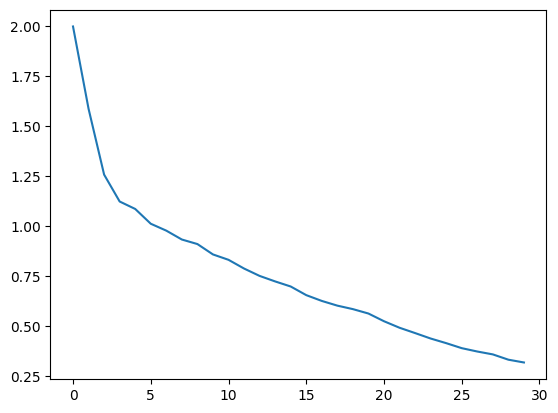

In [40]:
plt.plot(history)

In [39]:
src = 'Hello I am lost'
src = torch.tensor(data.src_vocab[src.split()])[None, :]

tgt = torch.tensor([data.tgt_vocab['<bos>']])[None, :]

pad = torch.tensor([src.shape[1]])

batch = [src, tgt, pad, torch.tensor([])]
pred, w = model.predict_step(batch, 'cpu', 8, save_attention_weights=True)

data.tgt_vocab.to_tokens(pred[0])

TypeError: Seq2SeqEncoder.forward() takes 2 positional arguments but 3 were given

## Multi-head attention

### Naive implementation

- Self attention linearly transforms input X into queries, keys, and values.
- Multihead attention concatenates N self attention blocks and linearly transforms these into an output. 

In [42]:
class SelfAttention(nn.Module):
    def __init__(self, n_hidden=16, dropout=0.1):
        super().__init__()
        self.queries = nn.LazyLinear(n_hidden, bias=False)
        self.keys = nn.LazyLinear(n_hidden, bias=False)
        self.values = nn.LazyLinear(n_hidden, bias=False)
        self.atts = DotProductAttention(dropout)
    
    def forward(self, Q, K, V, valid_length=None):
        Q = self.queries(Q)
        K = self.keys(K)
        V = self.values(V)
        
        return self.atts(Q, K, V, valid_length)
        
class MultiHeadAttention(nn.Module):
    
    def __init__(self, n_heads=4, n_hidden=16, dropout=0.1):
        super().__init__()
        self.n_heads = n_heads
        self.n_hidden = n_hidden
        self.att_blocks = nn.ModuleList([SelfAttention(int(n_hidden / n_heads), dropout) for _ in range(n_heads)])
        self.output = nn.Sequential(nn.LazyLinear(int(n_hidden / n_heads)), nn.Softmax(dim=-1))
    
    def forward(self, Q, K, V, valid_length=None):
        att_cat = torch.cat([self.output(att(Q, K, V, valid_length)) for att in self.att_blocks])
        output_cat = self.output(att_cat)
        output = output_cat.reshape(-1, output_cat.shape[1], output_cat.shape[2] * self.n_heads)
        return output

model = MultiHeadAttention(n_hidden=100, n_heads=5)
x = torch.randn(32, 4, 100) # queries: (batch_size, n_queries, n_hidden)
y = torch.randn(32, 6, 100) # keys/values: (batch_size, n_keysvalues, n_hidden)
model(x, y, y).shape # (batch_size, n_queries, n_hidden)

torch.Size([32, 4, 100])

### Parallelized implementation

In [43]:
class MultiHeadAttentionTensorOps(nn.Module):
    def __init__(self, n_hidden, n_heads, dropout=0.1, bias=False):
        super().__init__()
        self.n_heads = n_heads
        self.attention = DotProductAttention(dropout)
        self.W_q = nn.LazyLinear(n_hidden, bias=bias)
        self.W_k = nn.LazyLinear(n_hidden, bias=bias)
        self.W_v = nn.LazyLinear(n_hidden, bias=bias)
        self.W_o = nn.LazyLinear(n_hidden, bias=bias)
    
    def transpose_qkv(self, X: torch.Tensor):
        # Transpose input shape X
        # (batch_size, n_queries, n_hidden) into
        # (batch_size * num_heads, n_queries, n_hidden / n_heads)

        X = X.reshape(*X.shape[:2], self.n_heads, -1)   # (batch_size, n_queries, n_heads, n_hidden / n_heads)
        X = X.permute(0, 2, 1, 3)                       # (batch_size, n_heads, n_queries, n_hidden / n_heads)
        X = X.reshape(-1, *X.shape[2:])                 # (batch_size * n_heads, n_queries, n_hidden / n_heads)
        return X

    def transpose_output(self, X: torch.Tensor):
        # reverse transpose_qkv
        # (batch_size * num_heads, n_queries, n_hidden / n_heads) into
        # (batch_size, n_queries, n_hidden)

        X = X.reshape(-1, self.n_heads, *X.shape[1:])   # (batch_size, n_heads, n_queries, n_hidden / n_heads)
        X = X.permute(0, 2, 1, 3)                       # (batch_size, n_queries, n_heads, n_hidden / n_heads)
        X = X.reshape(*X.shape[:2], -1)                 # (batch_size, n_queries, n_heads, n_hidden / n_heads)
        return X
    
    def forward(self, queries: torch.Tensor, keys: torch.Tensor, values: torch.Tensor, valid_lengths=None):
        # shape queries, keys, values: (batch_size, n_queries or n_keyvalue_pairs, n_hidden)
        # shape valid_lengths: (batch_size, ) or (batch_size, n_queries)
        
        queries = self.transpose_qkv(self.W_q(queries))
        keys = self.transpose_qkv(self.W_q(keys))
        values = self.transpose_qkv(self.W_q(values))
        # after transposing, shape queries, keys, values: 
        # (batch_size * n_heads, n_queries or n_keyvalue_pairs, n_hidden / n_heads)
        
        if valid_lengths is not None:
            # (batch_size, ) --> (batch_size, n_heads)
            # (batch_size, n_queries) --> (batch_size, n_heads, n_queries)
            valid_lengths = torch.repeat_interleave(valid_lengths, repeats=self.n_heads, dim=0)
        
        output = self.attention(queries, keys, values, valid_lengths) # (batch_size * n_heads, n_queries, n_hidden / n_heads)
        output = self.transpose_output(output) # (batch_size, n_queries, n_hidden)
        return self.W_o(output)

m = MultiHeadAttentionTensorOps(n_hidden=16, n_heads=4)
x = torch.randn(32, 8, 16)
m_T = m.transpose_qkv(x) # transpose according to n_heads
m_T.shape, m.transpose_output(m_T).shape # transpose back to x

(torch.Size([128, 8, 4]), torch.Size([32, 8, 16]))

In [44]:
# test implementation for input-output shapes

model = MultiHeadAttentionTensorOps(n_hidden=100, n_heads=5, dropout=0.5)
x = torch.randn(32, 4, 100) # queries: (batch_size, n_queries, n_hidden)
y = torch.randn(32, 6, 100) # keys/values: (batch_size, n_keysvalues, n_hidden)
model(x, y, y).shape # (batch_size, n_queries, n_hidden)

torch.Size([32, 4, 100])

### Self-attention

- Use X as queries, keys, and values
- $ Y = \text{Attention}(X, X, X)$

In [45]:
model = MultiHeadAttentionTensorOps(n_hidden=100, n_heads=5, dropout=0.5)
x = torch.randn(32, 4, 100) # queries: (batch_size, n_queries, n_hidden)
model(x, x, x).shape # (batch_size, n_queries, n_hidden)

torch.Size([32, 4, 100])

## Transformer Architecture

### Position-wise feedforward network

In [46]:
class PositionWiseFFN(nn.Module):
    def __init__(self, ffn_n_hidden, ffn_n_outputs):
        super().__init__()
        self.dense1 = nn.LazyLinear(ffn_n_hidden)
        self.relu = nn.ReLU()
        self.dense2 = nn.LazyLinear(ffn_n_outputs)
        
    def forward(self, X: torch.Tensor):
        return self.dense2(self.relu(self.dense1(X)))

ffn = PositionWiseFFN(4, 8)
x = torch.randn(32, 3, 4)
ffn(x).shape

torch.Size([32, 3, 8])

### Residual addition and layer normalisation

Y = Norm(X + f(X))

In [47]:
class AddNorm(nn.Module):
    def __init__(self, norm_shape, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(norm_shape)
    
    def forward(self, X: torch.Tensor, Y: torch.Tensor):
        return self.layer_norm(self.dropout(Y) + X)

add_norm = AddNorm(4)
x, y = torch.randn(2, 32, 8, 4)
add_norm(x, y).shape

torch.Size([32, 8, 4])

### A single Transformer encoder block

In [48]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, n_hidden, ffn_n_hidden, n_heads, dropout=0.1, use_bias=False):
        super().__init__()
        self.attention = MultiHeadAttentionTensorOps(n_hidden, n_heads, dropout, use_bias)
        self.add_norm1 = AddNorm(n_hidden, dropout)
        self.ffn = PositionWiseFFN(ffn_n_hidden, n_hidden)
        self.add_norm2 = AddNorm(n_hidden, dropout)
    
    def forward(self, X: torch.Tensor, valid_lengths: torch.Tensor = None):
        sublayer1 = self.add_norm1(X, self.attention(X, X, X, valid_lengths))
        sublayer2 = self.add_norm2(sublayer1, self.ffn(sublayer1))
        return sublayer2

enc_block = TransformerEncoderBlock(16, 30, 4)
x = torch.randn(32, 8, 16) # (batch_size, n_queries, n_hidden)
enc_block(x).shape

torch.Size([32, 8, 16])

### Stack of transformer encoder blocks

In [49]:
class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, n_blocks, n_hidden, ffn_n_hidden, n_heads, dropout=0.1, use_bias=False):
        super().__init__()
        self.n_hidden = n_hidden
        self.embedding = nn.Embedding(vocab_size, n_hidden)
        self.pos_embedding = nn.Embedding(vocab_size, n_hidden)
        self.blocks = nn.Sequential()
        for i in range(n_blocks):
            self.blocks.add_module(f'block_{i}', TransformerEncoderBlock(n_hidden, ffn_n_hidden, n_heads, dropout, use_bias))
        self.attention_weights = None
        
    def forward(self, X: torch.Tensor, valid_lengths: torch.Tensor = None):
        seq_emb = self.embedding(X)
        pos_emb = self.pos_embedding(torch.arange(X.shape[-1]))
        X = seq_emb + pos_emb
        
        self.attention_weights = [None] * len(self.blocks)
        for i, block in enumerate(self.blocks):
            X = block(X, valid_lengths)
            self.attention_weights[i] = block.attention.attention.attention_weights
        
        return X

encoder = TransformerEncoder(200, 5, 16, 48, 4)
x = torch.ones((32, 8), dtype=torch.long) # (batch_size, n_queries (token_idx))
encoder(x).shape # (batch_size, n_queries, n_hidden)

torch.Size([32, 8, 16])

### A single Transformer decoder block

In [50]:
class TransformerDecoderBlock(nn.Module):
    def __init__(self, n_hidden, ffn_n_hidden, n_heads, i, dropout=0.1):
        super().__init__()
        self.i = i # ith decoder block
        self.attention1 = MultiHeadAttentionTensorOps(n_hidden, n_heads, dropout)
        self.add_norm1 = AddNorm(n_hidden, dropout)
        
        self.attention2 = MultiHeadAttentionTensorOps(n_hidden, n_heads, dropout)
        self.add_norm2 = AddNorm(n_hidden, dropout)
        
        self.ffn = PositionWiseFFN(ffn_n_hidden, n_hidden)
        self.add_norm3 = AddNorm(n_hidden, dropout)
        
    def forward(self, X: torch.Tensor, state: list[torch.Tensor]):
        # state[0] encoder outputs: (batch_size, n_queries (steps), n_hidden)
        # state[1] encoder valid lengths: (batch_size, ) or (batch_size, n_queries)
        # state[2] sequence of keys/values of all steps up until this step: (batch_size, n_queries (steps), n_hidden) 
        enc_outputs, enc_valid_lens = state[0], state[1]
        
        if state[2][self.i] is None:
            key_values = X # no state yet
        else:
            # concatenate previous steps and X
            # shape: (batch_size, n_queries+1, n_hidden)
            key_values = torch.cat([state[2][self.i], X], dim=1)
        
        state[2][self.i] = key_values
        
        if self.training:
            batch_size, n_steps, _ = X.shape
            # shape dec_valid_lens: (batch_size, n_steps)
            dec_valid_lens = torch.arange(1, n_steps+1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None
        
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.add_norm1(X, X2)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.add_norm2(Y, Y2)
        return self.add_norm3(Z, self.ffn(Z)), state
        
encoder_block = TransformerEncoderBlock(n_hidden=24, ffn_n_hidden=48, n_heads=8)
decoder_block = TransformerDecoderBlock(n_hidden=24, ffn_n_hidden=48, n_heads=8, i=0)

valid_lens = torch.tensor([3, 2])
x = torch.randn(2, 100, 24)
state = [encoder_block(x, valid_lens), valid_lens, [None]]
out, state = decoder_block(x, state)

out.shape, state[0].shape, state[1].shape, state[2][0].shape

(torch.Size([2, 100, 24]),
 torch.Size([2, 100, 24]),
 torch.Size([2]),
 torch.Size([2, 100, 24]))

### Stack of transformer decoder blocks

In [51]:
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, n_blocks, n_hidden, ffn_n_hidden, n_heads, dropout=0.1):
        super().__init__()
        self.n_hidden = n_hidden
        self.n_blocks = n_blocks
        self.embedding = nn.Embedding(vocab_size, n_hidden)
        self.pos_embedding = nn.Embedding(vocab_size, n_hidden)
        self.blocks = nn.Sequential()
        for i in range(n_blocks):
            self.blocks.add_module(f'block_{i}', TransformerDecoderBlock(n_hidden, ffn_n_hidden, n_heads, i, dropout))
        self.dense = nn.LazyLinear(vocab_size)
        self.attention_weights = None
        
    def init_state(self, enc_outputs, enc_valid_lens):
        return [enc_outputs, enc_valid_lens, [None] * self.n_blocks]
    
    def forward(self, X: torch.Tensor, state: list[torch.Tensor]):
        seq_emb = self.embedding(X)
        pos_emb = self.pos_embedding(torch.arange(X.shape[-1]))
        X = seq_emb + pos_emb
        
        self.attention_weights = [[None] * len(self.blocks) for _ in range(2)]
        for i, block in enumerate(self.blocks):
            X, state = block(X, state)
            
            # self attention
            self.attention_weights[0][i] = block.attention1.attention.attention_weights
            # cross attention
            self.attention_weights[1][i] = block.attention1.attention.attention_weights
        
        return self.dense(X), state

### Testing on english-french translation dataset

epoch=0, batch loss=1.8548697857629686
epoch=1, batch loss=1.1488863740648543
epoch=2, batch loss=0.987425841036297
epoch=3, batch loss=0.8753290971120199
epoch=4, batch loss=0.8058022856712341
epoch=5, batch loss=0.6978541499092465
epoch=6, batch loss=0.6159270866995766
epoch=7, batch loss=0.5459292907090414
epoch=8, batch loss=0.484122206057821
epoch=9, batch loss=0.4268064516640845
epoch=10, batch loss=0.3796181673450129
epoch=11, batch loss=0.34692862665369395
epoch=12, batch loss=0.34696669654832
epoch=13, batch loss=0.31057890433640706
epoch=14, batch loss=0.27870035517428604
epoch=15, batch loss=0.257286588173537
epoch=16, batch loss=0.25396195621717543
epoch=17, batch loss=0.25116691472274916
epoch=18, batch loss=0.2582519781731424
epoch=19, batch loss=0.2543241949308486
epoch=20, batch loss=0.2503275963522139
epoch=21, batch loss=0.24509486697968982
epoch=22, batch loss=0.27140845358371735
epoch=23, batch loss=0.3007378670431319
epoch=24, batch loss=0.28247316571928205
epoch=2

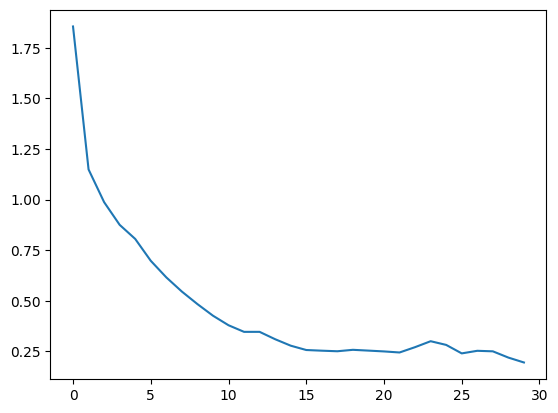

In [52]:
data = SeqFrenchEnglish(batch_size=32)
data_loader = data.get_dataloader()

n_hidden, n_blocks, dropout = 256, 2, 0.2
ffn_num_hidden, n_heads = 64, 4
EPOCH = 30

encoder = TransformerEncoder(len(data.src_vocab), n_blocks, n_hidden, ffn_num_hidden, n_heads, dropout)
decoder = TransformerDecoder(len(data.tgt_vocab), n_blocks, n_hidden, ffn_num_hidden, n_heads, dropout)
model = EncoderDecoder(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'])

optim = torch.optim.Adam(model.parameters(), lr=0.001)
history = []

for epoch in range(EPOCH):
    batch_loss = []
    for i, batch in enumerate(data_loader):
        src, tgt, pad, label = batch
        y_pred = model(src, tgt)
        y_pred = y_pred.transpose(1, 2)
        loss = F.cross_entropy(y_pred, label)
        batch_loss.append(loss.item())

        optim.zero_grad()
        loss.backward()
        optim.step()

    history.append(np.mean(batch_loss))
    print(f"{epoch=}, batch loss={history[-1]}")

plt.plot(history)

In [53]:
src = "I ' m going to buy some ?"
src = torch.tensor(data.src_vocab[src.split()])[None, :]

tgt = torch.tensor([data.tgt_vocab['<bos>']])[None, :]

pad = torch.tensor([src.shape[1]])

batch = [src, tgt, pad, torch.tensor([])]
pred, w = model.predict_step(batch, 'cpu', src.shape[-1], save_attention_weights=True)

data.tgt_vocab.to_tokens(pred[0])

["J'ai", "J'ai", "J'ai", "J'ai", "J'ai", "J'ai", "J'ai", "J'ai"]

In [64]:
torch.unsqueeze(batch[1][:, 0], 1)[-1]

tensor([3])

In [54]:
len(w)

8